# Download library

In [1]:
!pip install transformers==4.28.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 32.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 98.4 MB/s eta 0:00:00


In [2]:
!pip install accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.2/251.2 kB 2.5 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/huggingface/accelerate

  Cloning https://github.com/huggingface/accelerate to /tmp/pip-req-build-koh3zqwu
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/accelerate /tmp/pip-req-build-koh3zqwu
  Resolved https://github.com/huggingface/accelerate to commit 81b19c4094395db1be11150a900a92504190f7ac
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for accelerate: filename=accelerate-0.23.0.dev0-py3-none-any.whl size=251283 sha256=5a635f0fd407227cee79d58631427202fb3aa003a51ae6d503ceb940afda7e95
  Stored in directory: /tmp/pip-ephem-wheel-cache-shitekcg/wheels/f6/c7/9d/1b8a5ca8353d9307733bc719107acb67acdc95063bba749f26
Successfully built accelerate
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.22.0
    Uninstalling accelerate-0.22.0:
      Successfully uninstalled accelerate-0.22.0


In [4]:
# !pip install huggingface_hub

# Load data and pre-processing

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import os

os.environ['CURL_CA_BUNDLE'] = ''

In [7]:
import transformers
from transformers import AdamW, get_linear_schedule_with_warmup
from transformers import BertModel, BertTokenizer
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm.notebook import tqdm

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [8]:
df_p = pd.read_csv("/content/drive/MyDrive/data/processed/all_P.csv")
df_r = pd.read_csv("/content/drive/MyDrive/data/processed/all_R.csv")


In [10]:
df_r = df_r.rename(columns={"Mainlabel":"label"})
df_p = df_p.rename(columns={"Mainlabel":"label"})

In [11]:
P_labels=['information','design action', 'failure action','failure reasoning', 'perception']
R_labels=['introduction', 'clarification','workshop management', 'implementation', 'failure']

In [58]:
df_r_4=df_r[(df_r['label']=='introduction')| (df_r['label']=='failure')]
df_r_2=df_r[(df_r['label']=='implementation')]
df_r_1=df_r[(df_r['label']=='clarification')| (df_r['label']=='workshop management')]

df_p_3=df_p[(df_p['label']=='failure action')]
df_p_2=df_p[(df_p['label']=='information')| (df_p['label']=='perception')]
df_p_1=df_p[(df_p['label']=='design action')| (df_p['label']=='failure reasoning')]

In [59]:
df_r_4=df_r_4.append([df_r_4]*3,ignore_index=True)
df_r_2=df_r_2.append([df_r_2],ignore_index=True)

df_p_3=df_p_3.append([df_p_3]*2,ignore_index=True)
df_p_2=df_p_2.append([df_p_2],ignore_index=True)

<ipython-input-59-7e0f2a0e5be7>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_r_4=df_r_4.append([df_r_4]*3,ignore_index=True)
<ipython-input-59-7e0f2a0e5be7>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_r_2=df_r_2.append([df_r_2],ignore_index=True)
<ipython-input-59-7e0f2a0e5be7>:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p_3=df_p_3.append([df_p_3]*2,ignore_index=True)
<ipython-input-59-7e0f2a0e5be7>:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_p_2=df_p_2.append([df_p_2],ignore_index=True)


In [60]:
df_r_train=pd.concat([df_r_4, df_r_2, df_r_1 ])
df_p_train=pd.concat([df_p_3, df_p_2, df_p_1])

# Model

In [32]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

In [33]:
class MainDataset(Dataset):

    def __init__(self, text, targets, tokenizer, max_len):
        self.text = text
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, item):
        text = str(self.text[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(text,
                                              add_special_tokens=True,
                                              max_length=self.max_len,
                                              return_token_type_ids=False,
                                              pad_to_max_length=True,
                                              return_attention_mask=True,
                                              return_tensors='pt',
                                              truncation = True
                                             )
        return {'text': text,
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'targets': torch.tensor(target, dtype=torch.long)}

In [34]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = MainDataset(
    text=df['text'].to_numpy(),
    targets=df['index'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size
  )

In [35]:
class Classifier(nn.Module):

  def __init__(self, n_classes):
    super(Classifier, self).__init__()
    self.bert = BertModel.from_pretrained('bert-base-cased')
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

  def forward(self, input_ids, attention_mask,return_dict=False):
    _, pooled_output = self.bert(input_ids=input_ids,attention_mask=attention_mask, return_dict=False)
    output = self.drop(pooled_output)
    return self.out(output)

In [36]:
import torch
torch.cuda.empty_cache()

In [37]:
class Train_Model:

  def __init__(self, model, loss_fn, optimizer, device, scheduler, n_examples):
    self.model=model
    self.loss_fn=loss_fn
    self.optimizer=optimizer
    self.device=device
    self.scheduler=scheduler
    self.n_examples=n_examples

  def train_epoch(self, train_data_loader):
    model = self.model.train()

    losses = []
    correct_predictions = 0

    for d in tqdm(train_data_loader):
      input_ids = d["input_ids"].to(self.device)
      attention_mask = d["attention_mask"].to(self.device)
      targets = d["targets"].to(self.device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask, return_dict=False
      )

      _, preds = torch.max(outputs, dim=1)
      loss = self.loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

      loss.backward()
      nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
      self.optimizer.step()
      self.scheduler.step()
      self.optimizer.zero_grad()

    return correct_predictions.double() / self.n_examples, np.mean(losses)

  def eval_model(self, val_data_loader):
      model = self.model.eval()

      losses = []
      correct_predictions = 0

      with torch.no_grad():
        for d in tqdm(val_data_loader):
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,return_dict=False
          )
          _, preds = torch.max(outputs, dim=1)

          loss = self.loss_fn(outputs, targets)

          correct_predictions += torch.sum(preds == targets)
          losses.append(loss.item())

      return correct_predictions.double() / self.n_examples, np.mean(losses)

  def get_predictions(self, test_data_loader):
      model = self.model.eval()

      texts = []
      predictions = []
      prediction_probs = []
      real_values = []

      with torch.no_grad():
        for d in test_data_loader:

          text = d["text"]
          input_ids = d["input_ids"].to(self.device)
          attention_mask = d["attention_mask"].to(self.device)
          targets = d["targets"].to(self.device)

          outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
          )
          _, preds = torch.max(outputs, dim=1)

          probs = F.softmax(outputs, dim=1)

          texts.extend(text)
          predictions.extend(preds)
          prediction_probs.extend(probs)
          real_values.extend(targets)

      predictions = torch.stack(predictions).cpu()
      prediction_probs = torch.stack(prediction_probs).cpu()
      real_values = torch.stack(real_values).cpu()
      return texts, predictions, prediction_probs, real_values

# Researcher

In [62]:
train_r, _train_r = train_test_split(df_r_train, test_size=0.2, random_state=42)
valid_r, test_r = train_test_split(df_r, test_size=0.5, random_state=42)

In [63]:
train_data_loader_r = create_data_loader(train_r, tokenizer, max_len=128, batch_size=16)
val_data_loader_r = create_data_loader(valid_r, tokenizer, max_len=128, batch_size=16)
test_data_loader_r = create_data_loader(test_r, tokenizer, max_len=128, batch_size=16)

In [64]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [65]:
# define parameters
EPOCHS = 20

model = Classifier(len(R_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_r) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

R_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_r))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [66]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = R_model_train.train_epoch(train_data_loader_r)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = R_model_train.eval_model(val_data_loader_r)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.424420396698282 accuracy 0.40113182423435423


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.9031416631080735 accuracy 0.2533288948069241

Epoch 2/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.7111530141469012 accuracy 0.7586551264980027


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.5086904594176253 accuracy 0.3189081225033289

Epoch 3/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.2857540181956868 accuracy 0.911451398135819


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.27414424625605766 accuracy 0.3488681757656458

Epoch 4/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.11205590147515164 accuracy 0.9677097203728363


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.23739576882938526 accuracy 0.35985352862849534

Epoch 5/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.059191122244265766 accuracy 0.9823568575233024


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.2572276354947744 accuracy 0.3601864181091878

Epoch 6/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.023326230713753327 accuracy 0.9930093209054595


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.24221004306791272 accuracy 0.3628495339547271

Epoch 7/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.016480494889695732 accuracy 0.9960053262316911


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.25687731812506404 accuracy 0.36185086551264983

Epoch 8/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.014571117313530425 accuracy 0.9953395472703064


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.26179890435444797 accuracy 0.36251664447403464

Epoch 9/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.01063028785745004 accuracy 0.9970039946737683


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.2728660246246645 accuracy 0.36251664447403464

Epoch 10/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.006637215034409545 accuracy 0.9976697736351532


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.2693832686497227 accuracy 0.3628495339547271

Epoch 11/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.00637128050120156 accuracy 0.9980026631158456


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.28563220607703815 accuracy 0.36318242343541945

Epoch 12/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.005208766629638898 accuracy 0.9986684420772304


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.2916551587615788 accuracy 0.36251664447403464

Epoch 13/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.0037132604798472964 accuracy 0.9990013315579228


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.28499686204468416 accuracy 0.3628495339547271

Epoch 14/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.0029629836307263915 accuracy 0.9990013315579228


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.28960675394302315 accuracy 0.36318242343541945

Epoch 15/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.0020749116582861617 accuracy 0.9993342210386152


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.3006977216329534 accuracy 0.3628495339547271

Epoch 16/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.002157003114336205 accuracy 0.9993342210386152


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.2966585956054984 accuracy 0.3628495339547271

Epoch 17/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.0017041575938105296 accuracy 0.9993342210386152


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.2962141629852827 accuracy 0.3628495339547271

Epoch 18/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.0016811219029477797 accuracy 0.9993342210386152


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.28632549441066607 accuracy 0.36318242343541945

Epoch 19/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.0017997464822249814 accuracy 0.9990013315579228


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.27923766447355786 accuracy 0.36318242343541945

Epoch 20/20
----------


  0%|          | 0/188 [00:00<?, ?it/s]

Train loss 0.001993298498610842 accuracy 0.9993342210386152


  0%|          | 0/71 [00:00<?, ?it/s]

Val loss 0.2798881278546284 accuracy 0.36318242343541945



In [67]:
y_texts, y_pred, y_pred_probs, y_test = R_model_train.get_predictions(test_data_loader_r)

In [68]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.9762602981955553

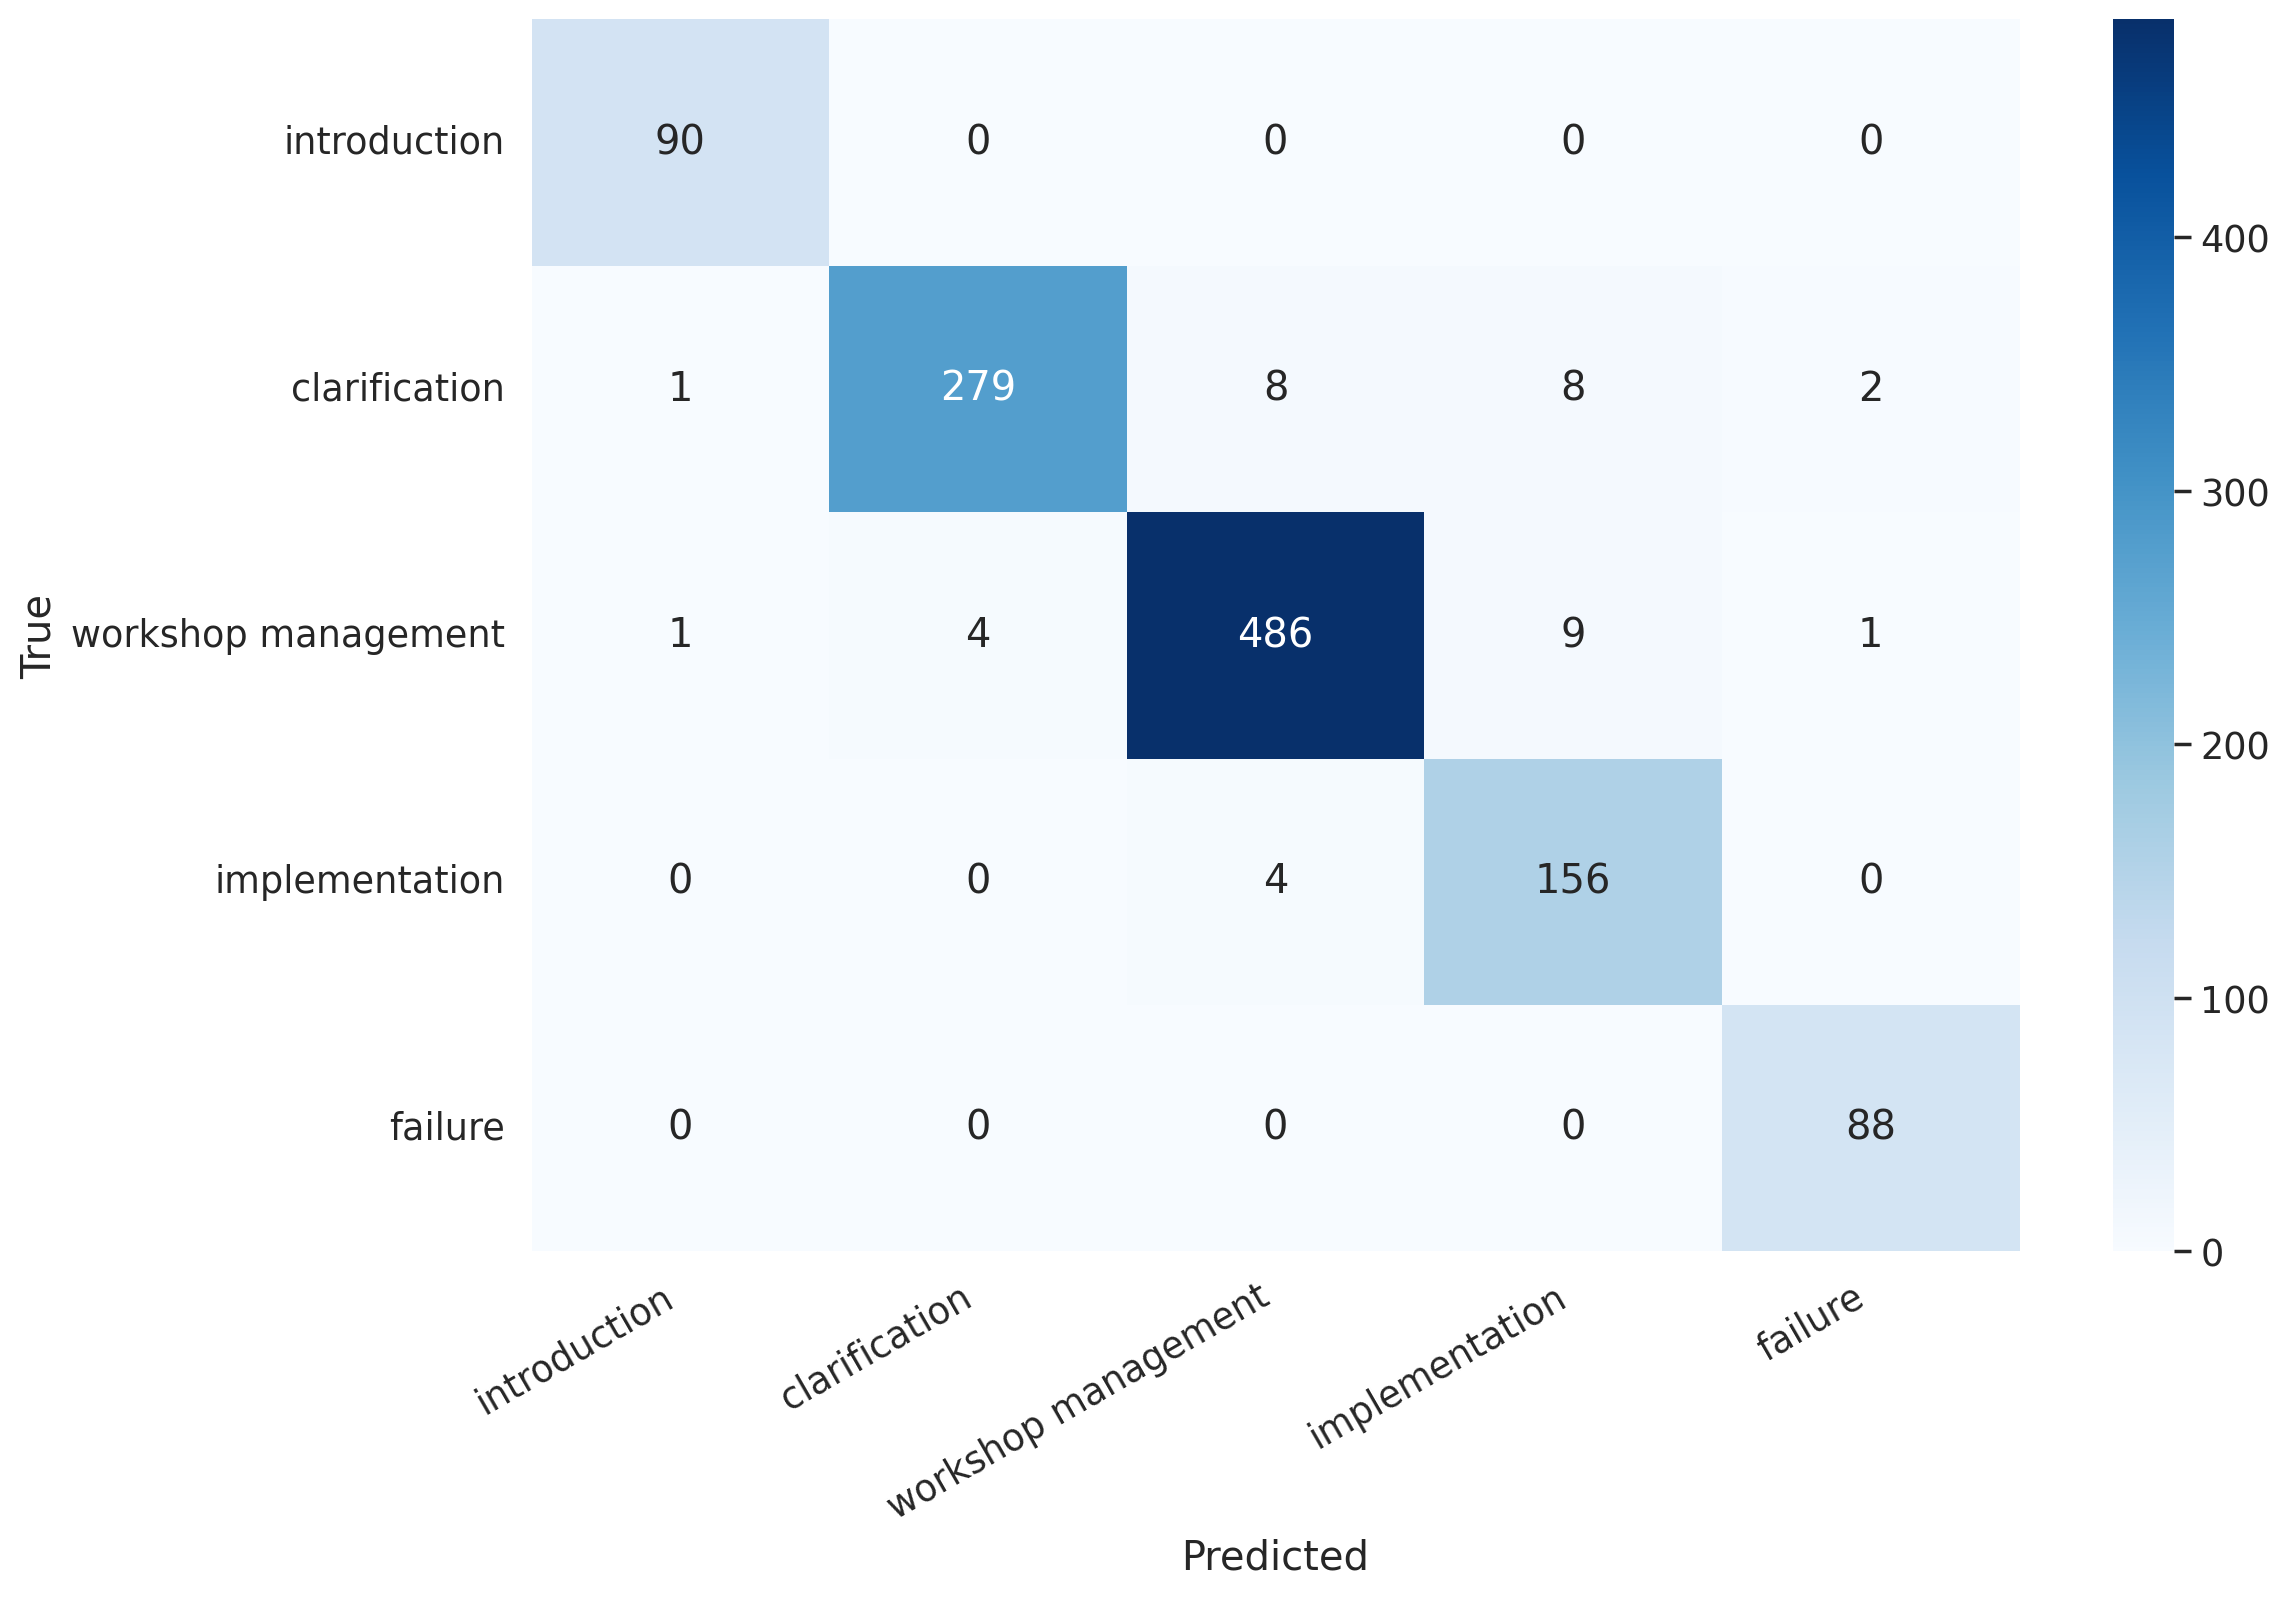

In [69]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=R_labels, columns=R_labels)
show_confusion_matrix(df_cm)

In [70]:
print(classification_report(y_test, y_pred, target_names=R_labels))

                     precision    recall  f1-score   support

       introduction       0.98      1.00      0.99        90
      clarification       0.99      0.94      0.96       298
workshop management       0.98      0.97      0.97       501
     implementation       0.90      0.97      0.94       160
            failure       0.97      1.00      0.98        88

           accuracy                           0.97      1137
          macro avg       0.96      0.98      0.97      1137
       weighted avg       0.97      0.97      0.97      1137



# Participant

In [71]:
train_p, _train_p = train_test_split(df_p_train, test_size=0.2, random_state=42)
valid_p, test_p = train_test_split(df_p, test_size=0.5, random_state=42)

In [72]:
train_data_loader_p = create_data_loader(train_p, tokenizer, max_len=128, batch_size=16)
val_data_loader_p = create_data_loader(valid_p, tokenizer, max_len=128, batch_size=16)
test_data_loader_p = create_data_loader(test_p, tokenizer, max_len=128, batch_size=16)

In [73]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [74]:
# define parameters
EPOCHS = 20

model = Classifier(len(P_labels))
model = model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader_p) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps)

loss_fn = nn.CrossEntropyLoss().to(device)

# define researcher's model

P_model_train=Train_Model(model, loss_fn, optimizer, device, scheduler, len(train_p))

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a 

In [75]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = P_model_train.train_epoch(train_data_loader_p)

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = P_model_train.eval_model(val_data_loader_p)

  print(f'Val loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.4089234818273515 accuracy 0.4049625468164794


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 1.047604337073209 accuracy 0.24625468164794007

Epoch 2/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.8549752491178797 accuracy 0.6694756554307116


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.4996947850051679 accuracy 0.35720973782771537

Epoch 3/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.37752408236821194 accuracy 0.8689138576779026


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.38041260747010247 accuracy 0.374063670411985

Epoch 4/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.16653436956815978 accuracy 0.9466292134831461


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.3795649425959901 accuracy 0.3848314606741573

Epoch 5/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.06586729689004289 accuracy 0.9784644194756554


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.38073106954413416 accuracy 0.3904494382022472

Epoch 6/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.028518240815879944 accuracy 0.9929775280898877


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.4761756884369166 accuracy 0.3890449438202247

Epoch 7/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.015273721598057465 accuracy 0.9962546816479401


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.4181212185199879 accuracy 0.3946629213483146

Epoch 8/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.006023422831412294 accuracy 0.9990636704119851


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.44923341875638517 accuracy 0.3955992509363296

Epoch 9/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.004090289393728321 accuracy 0.9995318352059925


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.4655420944557256 accuracy 0.39419475655430714

Epoch 10/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.0049253672212814055 accuracy 0.9990636704119851


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.48464784478965794 accuracy 0.3951310861423221

Epoch 11/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.002741904132400028 accuracy 0.9995318352059925


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.43090317686641866 accuracy 0.39653558052434457

Epoch 12/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.003139132448322654 accuracy 0.9995318352059925


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.44209040145914624 accuracy 0.39794007490636707

Epoch 13/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.002747661811269215 accuracy 0.9995318352059925


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.4522397837643981 accuracy 0.39653558052434457

Epoch 14/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.005431102327707071 accuracy 0.9990636704119851


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.4788926117900318 accuracy 0.3951310861423221

Epoch 15/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.002583127299848416 accuracy 0.9995318352059925


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.4878449938201301 accuracy 0.3951310861423221

Epoch 16/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.0022082992574398116 accuracy 0.9995318352059925


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.486485098492203 accuracy 0.3951310861423221

Epoch 17/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.002526355125318427 accuracy 0.9995318352059925


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.4897777718676177 accuracy 0.3951310861423221

Epoch 18/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.0028788305408757446 accuracy 0.9990636704119851


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.5009143975864087 accuracy 0.3946629213483146

Epoch 19/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.002462610622794965 accuracy 0.9995318352059925


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.49543914260950833 accuracy 0.3946629213483146

Epoch 20/20
----------


  0%|          | 0/134 [00:00<?, ?it/s]

Train loss 0.002054815051152802 accuracy 0.9995318352059925


  0%|          | 0/57 [00:00<?, ?it/s]

Val loss 0.491972962108552 accuracy 0.3946629213483146



In [76]:
y_texts, y_pred, y_pred_probs, y_test = P_model_train.get_predictions(test_data_loader_p)

In [77]:
from sklearn.metrics import balanced_accuracy_score

acc=balanced_accuracy_score(y_test, y_pred)
acc

0.9631286646752958

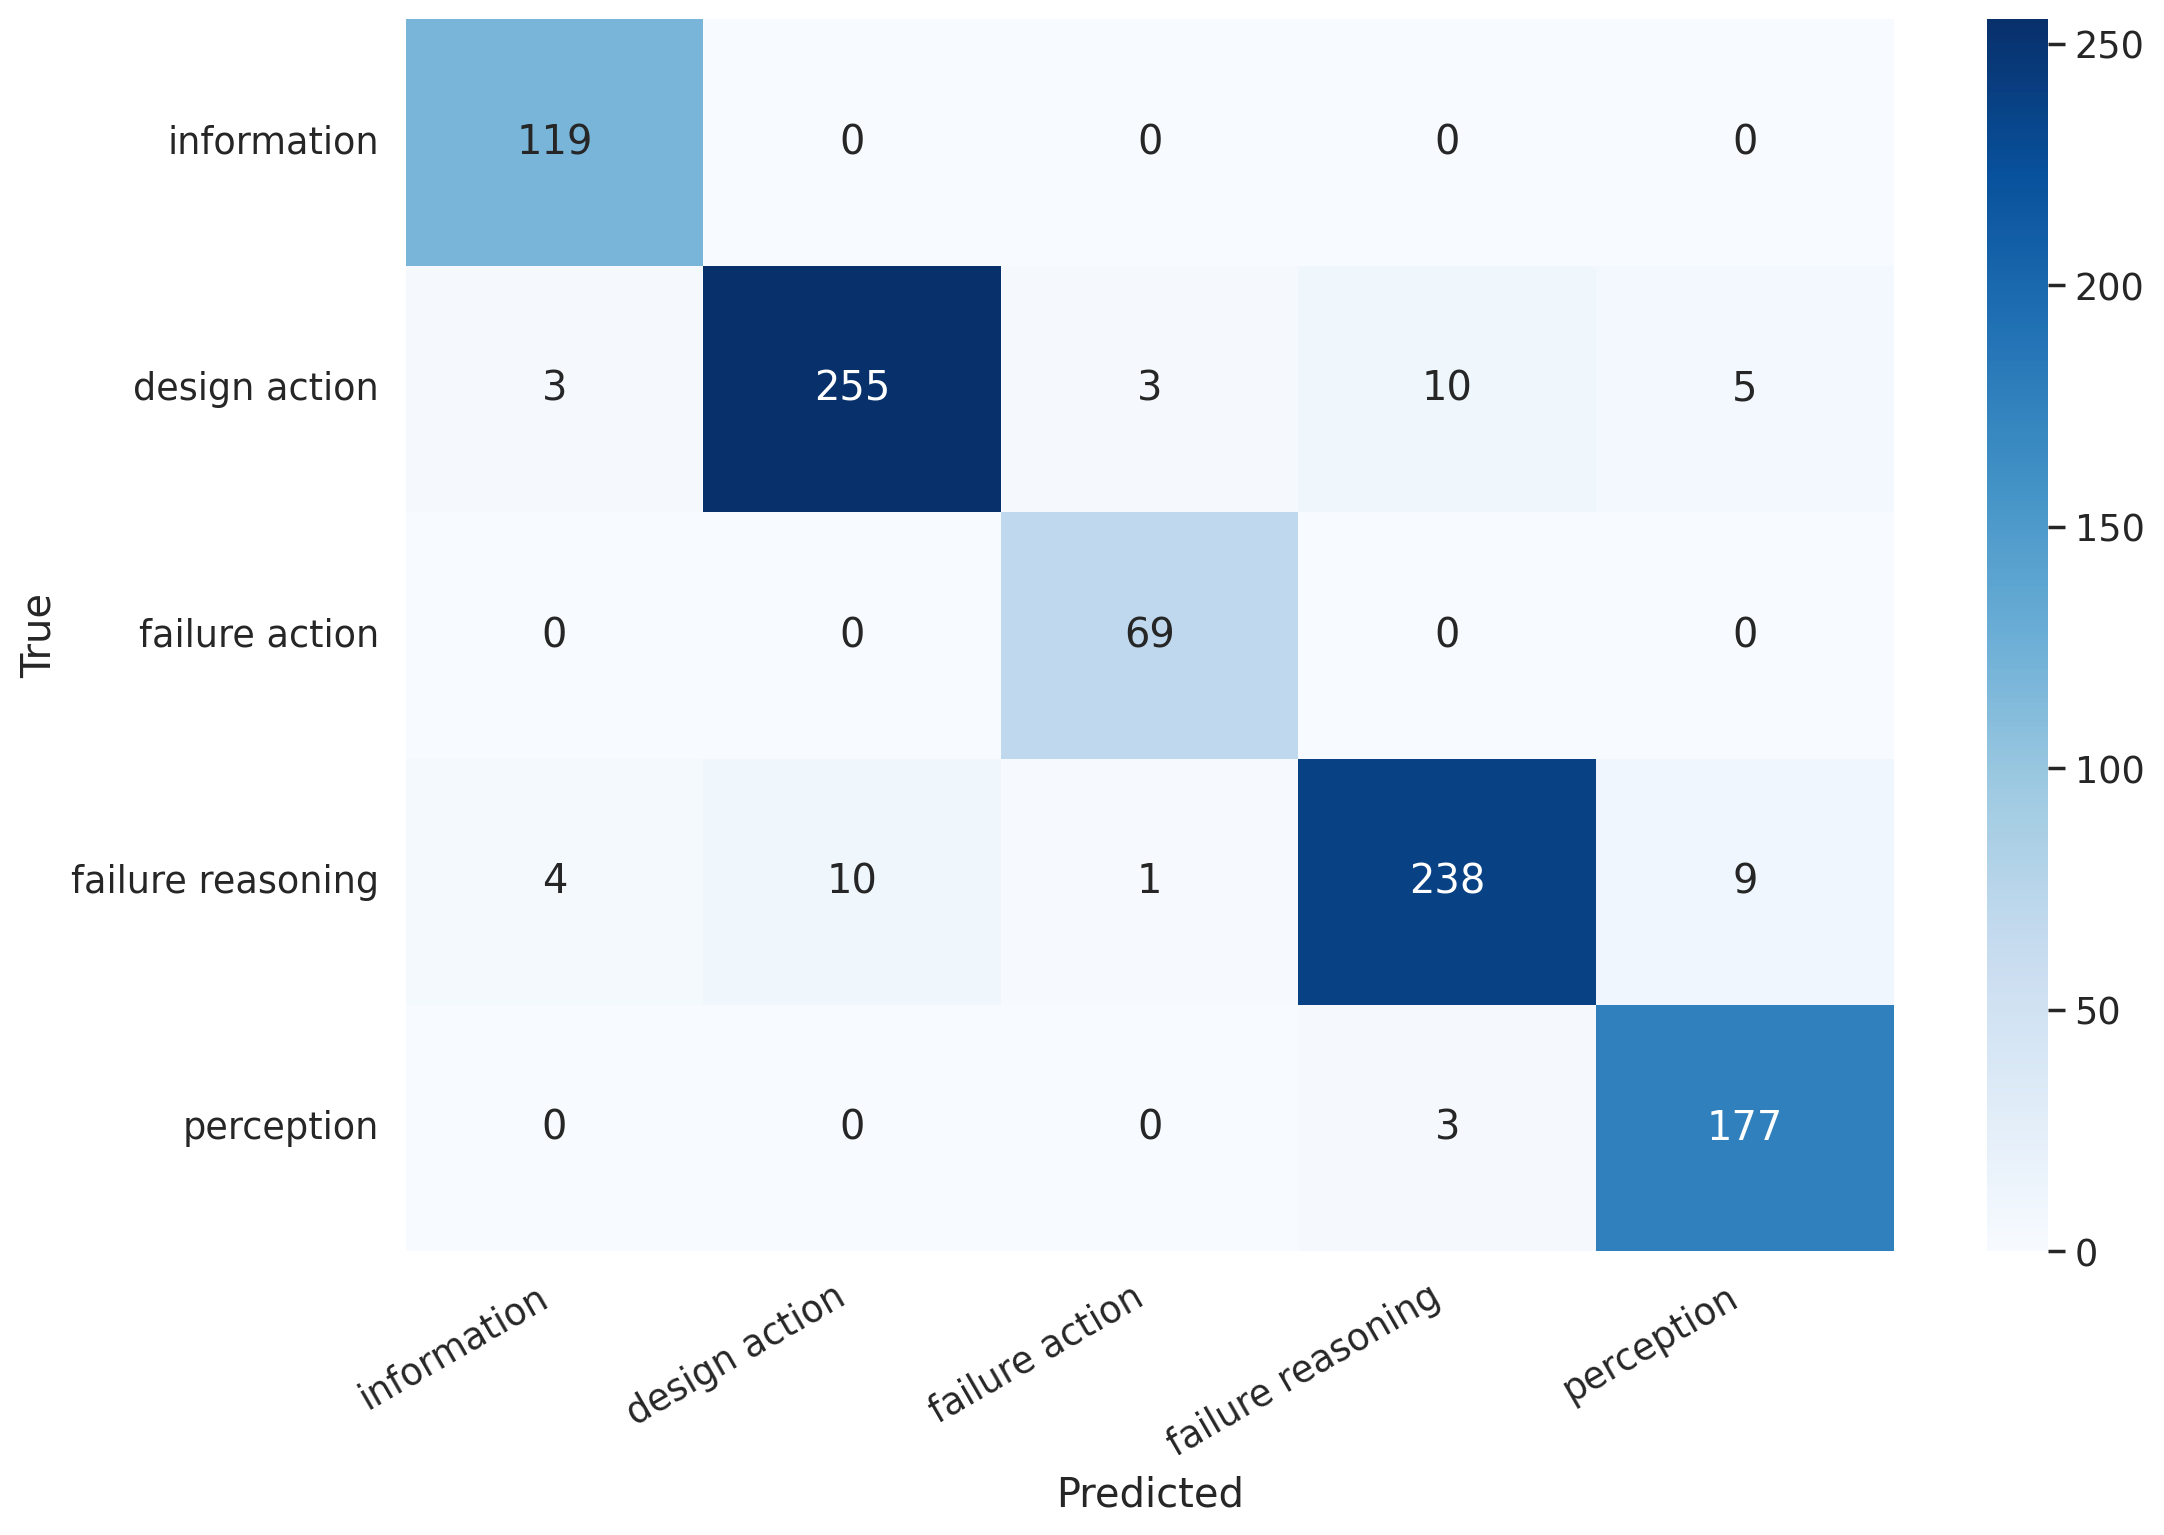

In [78]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True')
  plt.xlabel('Predicted');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=P_labels, columns=P_labels)
show_confusion_matrix(df_cm)

In [79]:
print(classification_report(y_test, y_pred, target_names=P_labels))

                   precision    recall  f1-score   support

      information       0.94      1.00      0.97       119
    design action       0.96      0.92      0.94       276
   failure action       0.95      1.00      0.97        69
failure reasoning       0.95      0.91      0.93       262
       perception       0.93      0.98      0.95       180

         accuracy                           0.95       906
        macro avg       0.95      0.96      0.95       906
     weighted avg       0.95      0.95      0.95       906

